<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [136]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Load data

In [137]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [138]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [139]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [140]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333


In [141]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [142]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [143]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [144]:
df.head()

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581


In [145]:
df.tail()

,A,B,C,D,E,F
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333


In [146]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [147]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [148]:
df.to_numpy()

array([[ 0.72264256, -1.26365064, -0.73027723,  0.28643417, -1.33594749,
        -0.56596654],
       [ 0.76385751, -0.41234669, -0.71333895,  0.00515061,  0.21579985,
        -1.38570714],
       [-0.70830064, -1.47941952,  0.81872009, -0.55317767, -0.68195739,
        -0.28160899],
       [ 0.22274508, -1.56765715, -0.68312064,  1.75762614, -0.16352964,
         0.09150218],
       [ 0.24514177,  1.66874685, -0.73403099,  1.04740404,  0.52405618,
         0.00358053],
       [ 0.02855443, -0.44731799, -1.33835228,  0.99843859, -0.54260297,
         0.06489781],
       [-0.00765088,  0.88197537,  1.12870591, -1.56776152,  0.5289772 ,
         0.12421265],
       [-0.30571245, -0.77353179,  0.53680967,  2.1053625 , -1.60245271,
        -0.23833291]])

In [149]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [150]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.120160,-0.424150,-0.214361,0.509935,-0.382207,-0.273428
std,0.492213,1.154797,0.902666,1.217810,0.808102,0.508012
min,-0.708301,-1.567657,-1.338352,-1.567762,-1.602453,-1.385707
25%,-0.082166,-1.317593,-0.731216,-0.134431,-0.845455,-0.352698
50%,0.125650,-0.610425,-0.698230,0.642436,-0.353066,-0.117376
75%,0.364517,-0.088766,0.607287,1.224960,0.292864,0.071549
max,0.763858,1.668747,1.128706,2.105362,0.528977,0.124213


In [151]:
df

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333


In [152]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,0.722643,0.763858,-0.708301,0.222745,0.245142,0.028554,-0.007651,-0.305712
B,-1.263651,-0.412347,-1.479420,-1.567657,1.668747,-0.447318,0.881975,-0.773532
C,-0.730277,-0.713339,0.818720,-0.683121,-0.734031,-1.338352,1.128706,0.536810
D,0.286434,0.005151,-0.553178,1.757626,1.047404,0.998439,-1.567762,2.105362
E,-1.335947,0.215800,-0.681957,-0.163530,0.524056,-0.542603,0.528977,-1.602453
F,-0.565967,-1.385707,-0.281609,0.091502,0.003581,0.064898,0.124213,-0.238333


In [153]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,-0.565967,-1.335947,0.286434,-0.730277,-1.263651,0.722643
2023-01-02,-1.385707,0.215800,0.005151,-0.713339,-0.412347,0.763858
2023-01-03,-0.281609,-0.681957,-0.553178,0.818720,-1.479420,-0.708301
2023-01-04,0.091502,-0.163530,1.757626,-0.683121,-1.567657,0.222745
2023-01-05,0.003581,0.524056,1.047404,-0.734031,1.668747,0.245142
2023-01-06,0.064898,-0.542603,0.998439,-1.338352,-0.447318,0.028554
2023-01-07,0.124213,0.528977,-1.567762,1.128706,0.881975,-0.007651
2023-01-08,-0.238333,-1.602453,2.105362,0.536810,-0.773532,-0.305712


In [154]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581


In [155]:
df

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333


##Getting

In [156]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01    0.722643
2023-01-02    0.763858
2023-01-03   -0.708301
2023-01-04    0.222745
2023-01-05    0.245142
2023-01-06    0.028554
2023-01-07   -0.007651
2023-01-08   -0.305712
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [157]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609


In [158]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502


In [159]:
df

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333


##Selection by label

In [160]:
df.loc[dates[1]]

A    0.763858
B   -0.412347
C   -0.713339
D    0.005151
E    0.215800
F   -1.385707
Name: 2023-01-02 00:00:00, dtype: float64

In [161]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,0.722643,0.286434
2023-01-02,0.763858,0.005151
2023-01-03,-0.708301,-0.553178
2023-01-04,0.222745,1.757626
2023-01-05,0.245142,1.047404
2023-01-06,0.028554,0.998439
2023-01-07,-0.007651,-1.567762
2023-01-08,-0.305712,2.105362


In [162]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,0.222745,1.757626
2023-01-05,0.245142,1.047404
2023-01-06,0.028554,0.998439


In [163]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A    0.222745
D    1.757626
Name: 2023-01-04 00:00:00, dtype: float64

In [164]:
# For getting a scalar value
df.loc[dates[1], "D"]

0.005150607952513424

In [165]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

0.005150607952513424

##Selection by position

In [166]:
df.iloc[3]

A    0.222745
B   -1.567657
C   -0.683121
D    1.757626
E   -0.163530
F    0.091502
Name: 2023-01-04 00:00:00, dtype: float64

In [167]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,0.222745,-1.567657
2023-01-05,0.245142,1.668747


In [168]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,0.763858,-0.713339
2023-01-03,-0.708301,0.818720
2023-01-05,0.245142,-0.734031


In [169]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609


In [170]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,-1.263651,-0.730277
2023-01-02,-0.412347,-0.713339
2023-01-03,-1.479420,0.818720
2023-01-04,-1.567657,-0.683121
2023-01-05,1.668747,-0.734031
2023-01-06,-0.447318,-1.338352
2023-01-07,0.881975,1.128706
2023-01-08,-0.773532,0.536810


In [171]:
# For getting values explicitly
df.iloc[1, 1]

-0.41234668899651433

In [172]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

-0.41234668899651433

## Boolean indexing
Using a single column's values to select data:

In [173]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898


In [174]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,0.722643,NaN,NaN,0.286434,NaN,NaN
2023-01-02,0.763858,NaN,NaN,0.005151,0.215800,NaN
2023-01-03,NaN,NaN,0.818720,NaN,NaN,NaN
2023-01-04,0.222745,NaN,NaN,1.757626,NaN,0.091502
2023-01-05,0.245142,1.668747,NaN,1.047404,0.524056,0.003581
2023-01-06,0.028554,NaN,NaN,0.998439,NaN,0.064898
2023-01-07,NaN,0.881975,1.128706,NaN,0.528977,0.124213
2023-01-08,NaN,NaN,0.536810,2.105362,NaN,NaN


In [175]:
df

,A,B,C,D,E,F
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333


In [176]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,0.722643,-1.263651,-0.730277,0.286434,-1.335947,-0.565967,one
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707,one
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609,two
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502,three
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581,four
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898,three
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213,five
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333,four


In [177]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609,two
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581,four
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [178]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [179]:
df["G"] = s1

In [180]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [181]:
# Setting values by position:
df.iat[0, 1] = 0

In [182]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.730277,0.286434,-1.335947,-0.565967,NaN
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,0.215800,-1.385707,1.0
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,-0.681957,-0.281609,2.0
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,-0.163530,0.091502,3.0
2023-01-05,0.245142,1.668747,-0.734031,1.047404,0.524056,0.003581,4.0
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,-0.542603,0.064898,5.0
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,0.528977,0.124213,6.0
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,-1.602453,-0.238333,NaN


In [183]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [184]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.730277,0.286434,5,-0.565967,NaN
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,5,-1.385707,1.0
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,5,-0.281609,2.0
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,5,0.091502,3.0
2023-01-05,0.245142,1.668747,-0.734031,1.047404,5,0.003581,4.0
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,5,0.064898,5.0
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,5,0.124213,6.0
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,5,-0.238333,NaN


In [185]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.730277,-0.286434,-5,-0.565967,NaN
2023-01-02,-0.763858,-0.412347,-0.713339,-0.005151,-5,-1.385707,-1.0
2023-01-03,-0.708301,-1.479420,-0.818720,-0.553178,-5,-0.281609,-2.0
2023-01-04,-0.222745,-1.567657,-0.683121,-1.757626,-5,-0.091502,-3.0
2023-01-05,-0.245142,-1.668747,-0.734031,-1.047404,-5,-0.003581,-4.0
2023-01-06,-0.028554,-0.447318,-1.338352,-0.998439,-5,-0.064898,-5.0
2023-01-07,-0.007651,-0.881975,-1.128706,-1.567762,-5,-0.124213,-6.0
2023-01-08,-0.305712,-0.773532,-0.536810,-2.105362,-5,-0.238333,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [186]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.730277,0.286434,5,-0.565967,1.0,1.0
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,5,-1.385707,1.0,1.0
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,5,-0.281609,2.0,2.0
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,5,0.091502,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [187]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.730277,0.286434,5,-0.565967,1.0,1.0
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,5,-1.385707,1.0,1.0
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,5,-0.281609,2.0,2.0
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,5,0.091502,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [188]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.730277,0.286434,5,-0.565967,1.0,1.0
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,5,-1.385707,1.0,1.0
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,5,-0.281609,2.0,2.0
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,5,0.091502,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [189]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [190]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.730277,0.286434,5,-0.565967,NaN
2023-01-02,0.763858,-0.412347,-0.713339,0.005151,5,-1.385707,1.0
2023-01-03,-0.708301,-1.479420,0.818720,-0.553178,5,-0.281609,2.0
2023-01-04,0.222745,-1.567657,-0.683121,1.757626,5,0.091502,3.0
2023-01-05,0.245142,1.668747,-0.734031,1.047404,5,0.003581,4.0
2023-01-06,0.028554,-0.447318,-1.338352,0.998439,5,0.064898,5.0
2023-01-07,-0.007651,0.881975,1.128706,-1.567762,5,0.124213,6.0
2023-01-08,-0.305712,-0.773532,0.536810,2.105362,5,-0.238333,NaN


In [191]:
df.mean()

A    0.029829
B   -0.266194
C   -0.214361
D    0.509935
E    5.000000
F   -0.273428
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [192]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [193]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-1.708301,-2.479420,-0.181280,-1.553178,4.0,-1.281609,1.0
2023-01-04,-2.777255,-4.567657,-3.683121,-1.242374,2.0,-2.908498,0.0
2023-01-05,-3.754858,-2.331253,-4.734031,-2.952596,1.0,-3.996419,0.0
2023-01-06,-4.971446,-5.447318,-6.338352,-4.001561,0.0,-4.935102,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-6.305712,-6.773532,-5.463190,-3.894638,-1.0,-6.238333,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [194]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.730277,0.286434,5,-0.565967,NaN
2023-01-02,0.763858,-0.412347,-1.443616,0.291585,10,-1.951674,1.0
2023-01-03,0.055557,-1.891766,-0.624896,-0.261593,15,-2.233283,3.0
2023-01-04,0.278302,-3.459423,-1.308017,1.496033,20,-2.141781,6.0
2023-01-05,0.523444,-1.790677,-2.042048,2.543437,25,-2.138200,10.0
2023-01-06,0.551998,-2.237994,-3.380400,3.541876,30,-2.073302,15.0
2023-01-07,0.544347,-1.356019,-2.251694,1.974114,35,-1.949090,21.0
2023-01-08,0.238635,-2.129551,-1.714884,4.079477,40,-2.187422,NaN


In [195]:
df.apply(lambda x: x.max() - x.min())

A    1.472158
B    3.236404
C    2.467058
D    3.673124
E    0.000000
F    1.509920
G    5.000000
dtype: float64

##Histogramming

In [196]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    1
1    5
2    4
3    6
4    3
5    5
6    6
7    1
8    2
9    0
dtype: int64

In [197]:
s.value_counts()

1    2
5    2
6    2
4    1
3    1
2    1
0    1
dtype: int64

##String Methods


In [198]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [199]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,-0.315663,1.614209,1.476627,0.896980
1,-0.048087,1.280307,-0.987253,-1.013398
2,0.349267,-2.019594,0.282843,0.450707
3,1.097271,-0.770250,0.786125,-1.154352
4,-1.265377,0.557749,-0.296361,1.232089
5,-1.070411,-0.229456,0.689002,-0.771051
6,-0.008951,-1.665851,-0.464527,0.611958
7,0.624320,1.155034,-1.379730,0.403693
8,-0.341285,1.662912,0.791720,-1.135092
9,0.884926,0.380815,-0.717514,1.470848


In [200]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,-0.315663,1.614209,1.476627,0.896980
1,-0.048087,1.280307,-0.987253,-1.013398
2,0.349267,-2.019594,0.282843,0.450707
3,1.097271,-0.770250,0.786125,-1.154352
4,-1.265377,0.557749,-0.296361,1.232089
5,-1.070411,-0.229456,0.689002,-0.771051
6,-0.008951,-1.665851,-0.464527,0.611958
7,0.624320,1.155034,-1.379730,0.403693
8,-0.341285,1.662912,0.791720,-1.135092
9,0.884926,0.380815,-0.717514,1.470848


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [201]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [202]:
right

,key,rval
0,foo,4
1,foo,5


In [203]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [204]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [205]:
right

,key,rval
0,foo,4
1,bar,5


In [206]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [207]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,-0.058585,1.547659
1,bar,one,-0.956135,1.574081
2,foo,two,0.090656,0.987357
3,bar,three,-0.094416,-0.713880
4,foo,two,-0.772375,-0.547431
5,bar,two,0.532802,0.794469
6,foo,one,-0.303930,-2.287018
7,foo,three,-1.736863,0.890369


Grouping and then applying the `sum()` function to the resulting groups:

In [208]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-0.517749,1.654671
foo,-2.781097,0.590935


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [209]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -0.956135  1.574081
    three -0.094416 -0.713880
    two    0.532802  0.794469
foo one   -0.362515 -0.739360
    three -1.736863  0.890369
    two   -0.681719  0.439926

##Reshaping
**Stack**

In [210]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one    -0.082977  0.871697
      two    -2.895764 -1.000735
baz   one    -0.066895  0.413871
      two     0.036839 -0.435049

The `stack()` method "compresses" a level in the DataFrame's columns:

In [211]:
stacked = df2.stack()
stacked

first  second   
bar    one     A   -0.082977
               B    0.871697
       two     A   -2.895764
               B   -1.000735
baz    one     A   -0.066895
               B    0.413871
       two     A    0.036839
               B   -0.435049
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [212]:
stacked.unstack()

A         B
first second                    
bar   one    -0.082977  0.871697
      two    -2.895764 -1.000735
baz   one    -0.066895  0.413871
      two     0.036839 -0.435049

In [213]:
stacked.unstack(1)

second        one       two
first                      
bar   A -0.082977 -2.895764
      B  0.871697 -1.000735
baz   A -0.066895  0.036839
      B  0.413871 -0.435049

In [214]:
stacked.unstack(0)

first          bar       baz
second                      
one    A -0.082977 -0.066895
       B  0.871697  0.413871
two    A -2.895764  0.036839
       B -1.000735 -0.435049

##Pivot tables

In [215]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,-0.718290,1.049221
1,one,B,foo,-0.444599,-0.434923
2,two,C,foo,-0.880332,-0.436157
3,three,A,bar,1.440596,0.837532
4,one,B,bar,-0.548751,-0.120169
5,one,C,bar,0.237892,0.248273
6,two,A,foo,-0.096842,-0.407690
7,three,B,foo,-1.969723,-1.392990
8,one,C,foo,-0.777744,0.208253
9,one,A,bar,1.466029,-1.557314


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [216]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A  1.466029 -0.718290
      B -0.548751 -0.444599
      C  0.237892 -0.777744
three A  1.440596       NaN
      B       NaN -1.969723
      C -0.050935       NaN
two   A       NaN -0.096842
      B -1.682010       NaN
      C       NaN -0.880332

##Time series

In [217]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    25907
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [218]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06   -0.735697
2012-03-07    0.240520
2012-03-08   -0.290501
2012-03-09    0.120229
2012-03-10   -0.203900
Freq: D, dtype: float64

In [219]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00   -0.735697
2012-03-07 00:00:00+00:00    0.240520
2012-03-08 00:00:00+00:00   -0.290501
2012-03-09 00:00:00+00:00    0.120229
2012-03-10 00:00:00+00:00   -0.203900
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [220]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00   -0.735697
2012-03-06 19:00:00-05:00    0.240520
2012-03-07 19:00:00-05:00   -0.290501
2012-03-08 19:00:00-05:00    0.120229
2012-03-09 19:00:00-05:00   -0.203900
Freq: D, dtype: float64

Converting between time span representations:

In [221]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31   -0.363135
2012-02-29   -0.864546
2012-03-31    0.823047
2012-04-30    1.090015
2012-05-31    1.030211
Freq: M, dtype: float64

In [222]:
ps = ts.to_period()

ps 

2012-01   -0.363135
2012-02   -0.864546
2012-03    0.823047
2012-04    1.090015
2012-05    1.030211
Freq: M, dtype: float64

In [223]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01   -0.363135
2012-02-01   -0.864546
2012-03-01    0.823047
2012-04-01    1.090015
2012-05-01    1.030211
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [224]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00    0.296495
1990-06-01 09:00    0.208225
1990-09-01 09:00    0.019089
1990-12-01 09:00   -0.172815
1991-03-01 09:00    0.317858
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [225]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [226]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [227]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [228]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [229]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [230]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [231]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

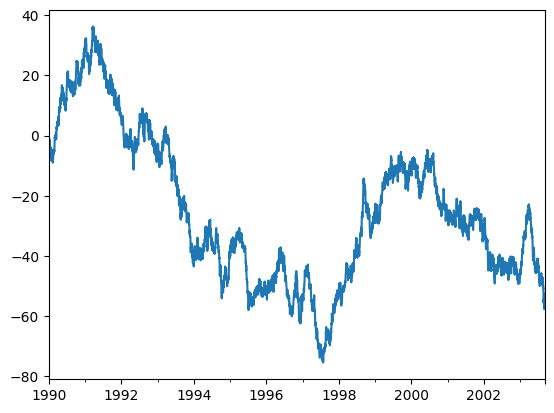

In [232]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [233]:
plt.show();

<Figure size 640x480 with 0 Axes>

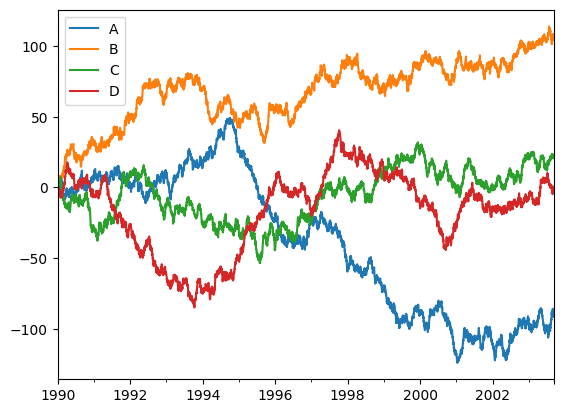

In [234]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [235]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [236]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.205301,0.854856,0.559432,0.560418
1,1990-01-02,-0.766401,2.727909,0.857313,1.655680
2,1990-01-03,-0.970186,2.513465,0.681418,0.767956
3,1990-01-04,-1.171360,1.714353,1.048285,0.365843
4,1990-01-05,-0.806123,1.568295,-0.323228,0.499470
...,...,...,...,...,...
4995,2003-09-05,-90.672902,106.278867,22.032250,0.537434
4996,2003-09-06,-91.163817,104.945336,21.924290,-0.244194
4997,2003-09-07,-90.875305,105.526385,22.410792,-0.284702
4998,2003-09-08,-91.370795,105.875526,20.586122,-0.297314


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [237]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [238]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,-0.205301,0.854856,0.559432,0.560418
1990-01-02,-0.766401,2.727909,0.857313,1.655680
1990-01-03,-0.970186,2.513465,0.681418,0.767956
1990-01-04,-1.171360,1.714353,1.048285,0.365843
1990-01-05,-0.806123,1.568295,-0.323228,0.499470
...,...,...,...,...
2003-09-05,-90.672902,106.278867,22.032250,0.537434
2003-09-06,-91.163817,104.945336,21.924290,-0.244194
2003-09-07,-90.875305,105.526385,22.410792,-0.284702
2003-09-08,-91.370795,105.875526,20.586122,-0.297314


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [239]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [240]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.205301,0.854856,0.559432,0.560418
1,1990-01-02,-0.766401,2.727909,0.857313,1.655680
2,1990-01-03,-0.970186,2.513465,0.681418,0.767956
3,1990-01-04,-1.171360,1.714353,1.048285,0.365843
4,1990-01-05,-0.806123,1.568295,-0.323228,0.499470
...,...,...,...,...,...
4995,2003-09-05,-90.672902,106.278867,22.032250,0.537434
4996,2003-09-06,-91.163817,104.945336,21.924290,-0.244194
4997,2003-09-07,-90.875305,105.526385,22.410792,-0.284702
4998,2003-09-08,-91.370795,105.875526,20.586122,-0.297314


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [241]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a    1.068967
b    0.895564
c   -0.492700
d    1.822978
e    1.693051
dtype: float64

In [242]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [243]:
pd.Series(np.random.randn(5))

0    0.589456
1   -0.927149
2    0.949978
3    1.682462
4   -0.589997
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [244]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [245]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [246]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [247]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [248]:
s[s>s.median()]

d    1.822978
e    1.693051
dtype: float64

In [249]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [250]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [252]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [253]:
bb[bb.columns[:9]].dtypes

Unnamed: 0                         object
Unnamed: 1                         object
Unnamed: 2                         object
Unnamed: 3                         object
Unnamed: 4                         object
Unnamed: 5                         object
Unnamed: 6                         object
Percent change\nJan 2023 from -    object
Unnamed: 8                         object
dtype: object

In [254]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

##PyTorch Forecasting
**Building a simple first model**

Starting witha simple fully connected model, it'll take a timeseries of size `input_size` as input and outputs a new timeseries of size `output_size`. 

In [271]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
    super().__init__()

    # input layer
    module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    # hidden layers
    for _ in range(n_hidden_layers):
        module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
    # output layer
    module_list.append(nn.Linear(hidden_size, output_size))

    self.sequential = nn.Sequential(*module_list)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x of shape: batch_size x n_timesteps_in
      # output of shape batch_size x n_timesteps_out
      return self.sequential(x)

# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])

The above model is not yet a PyTorch Forecasting model but it is easy to get there. As this is a simple model, we will use the `BaseModel`. This base class is modified `LightningModule` with pre-defined hooks for training and validating time series models. The main requirement is for the model to have a forward method.

In [273]:
def forward(self, x:
    # x is a batch generated based on TimeSeriesDataset, here we use the
    # continuous variables for encoder
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.linear(network_input)  #
    
    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])
    
    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

SyntaxError: ignored

In [274]:
from typing import Dict

from pytorch_forecasting.models import BaseModel

class FullyConnectedModule(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

##Passing data to a model

Instead of having to write our own dataloader, we can leverage PyTorch Forecasting’s `TimeSeriesDataSet` to feed data to our model. In fact, PyTorch Forecasting expects us to use a `TimeSeriesDataSet`.

The data has to be in a specific format to be used by the `TimeSeriesDataSet`. It should be in a pandas DataFrame and have a categorical column to identify each series and a integer column to specify the time of the record.

Below, we create such a dataset with 30 different observations - 10 for 3 time series.

In [275]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) -0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
test_data 

,value,group,time_idx
0,-0.206916,0,0
1,0.464842,0,1
2,-0.268998,0,2
3,0.294631,0,3
4,-0.039032,0,4
5,-0.435223,0,5
6,0.000501,0,6
7,-0.100579,0,7
8,0.175480,0,8
9,-0.469536,0,9


We can convert it to a `TimeSeriesDataSet` easily.

In [276]:
from pytorch_forecasting import TimeSeriesDataSet

# create the dataset from the pandas dataframe
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
)

We can take a look at all the defaults and settings preset by PyTorch Forecasting. These are all available as arguments in `TimeSeriesDataSet`.

In [277]:
dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 5,
 'min_encoder_length': 5,
 'min_prediction_idx': 0,
 'min_prediction_length': 2,
 'max_prediction_length': 2,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': GroupNormalizer(
 	method='standard',
 	groups=[],
 	center=True,
 	scale_by_group=False,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True),
  'group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

Now when we take a look at the output of the dataloader. It's `x` will be fed to the model's forward method.

In [278]:
# convert the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(4, 5, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-0.5244],
         [ 1.7376],
         [ 0.3985],
         [-1.1915],
         [ 0.5572]],

        [[ 1.6390],
         [-1.2836],
         [-0.2216],
         [-0.5309],
         [ 0.6638]],

        [[ 0.7951],
         [ 0.5801],
         [-1.0458],
         [-0.7791],
         [ 1.4838]],

        [[ 2.4207],
         [-0.5244],
         [ 1.7376],
         [ 0.3985],
         [-1.1915]]]), 'encoder_target': tensor([[-0.2690,  0.2946, -0.0390, -0.4352,  0.0005],
        [ 0.2701, -0.4582, -0.1935, -0.2706,  0.0271],
        [ 0.0598,  0.0062, -0.3989, -0.3325,  0.2314],
        [ 0.4648, -0.2690,  0.2946, -0.0390, -0.4352]]), 'encoder_lengths': tensor([5, 5, 5, 5]), 'decoder_cat': tensor([], size=(4, 2, 0), dtype=torch.int64), 'decoder_cont': tensor([[[ 0.1515],
         [ 1.2594]],

        [[-0.0064],
         [-0.7005]],

        [[-1.1585],
         [-1.0466]],

        [[ 0.5572],
   

Weight by samples for training:

In [280]:
from torch.utils.data import WeightedRandomSampler

# length of probabilties for sampler have to be equal to the length of the index
probabilities = np.sqrt(1 + data.loc[dataset.index, "target"])
sampler = WeightedRandomSampler(probabilities, len(probabilities))
dataset.to_dataloader(train=True, sampler=sampler, shuffle=False)

NameError: ignored

In [281]:
def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # x is a batch generated based on the TimeSeriesDataset
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.network(network_input)

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

In [282]:
model = FullyConnectedModel.from_dataset(dataset, input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x, y = next(iter(dataloader))
model(x)

NameError: ignored

In [283]:
dataset.x_to_index(x)

,time_idx,group
0,7,0
1,8,1
2,5,2
3,6,0


**Coupling datasets and models**

In [291]:
class FullyConnectedModule(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input).unsqueeze(-1)

        #rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        #We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversation to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs ={
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)